<a href="https://colab.research.google.com/github/Hotckiss/DUL/blob/hw3/hw3_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import Adam
import torch.distributions as D

In [0]:
def sample_data_1():
    count = 100000
    rand = np.random.RandomState(0)
    return [[1.0, 2.0]] + rand.randn(count, 2) * [[5.0, 1.0]]

In [0]:
def sample_data_2():
    count = 100000
    rand = np.random.RandomState(0)
    return [[1.0, 2.0]] + (rand.randn(count, 2) * [[5.0, 1.0]]).dot(
    [[np.sqrt(2) / 2, np.sqrt(2) / 2], [-np.sqrt(2) / 2, np.sqrt(2) / 2]])

In [0]:
def MyLoss(x, mu, var):
    log_prob = torch.sum(-0.5 * (torch.log(np.pi * 2 * var) + torch.pow(x - mu, 2) / var), dim=1, keepdim=True)
    return -torch.sum(log_prob, dim=1, keepdim=True)

In [0]:
def KLDiv(mu, var):
    return -0.5 * torch.sum((1.0 + torch.log(var) - torch.pow(mu, 2) - var), dim=1, keepdim=True)

In [0]:
def plot_data(data_, title_):
    ax = plt.subplot(111)
    ax.plot(np.arange(len(data_)), data_)
    ax.set_xlabel("n")
    ax.set_title(title_)

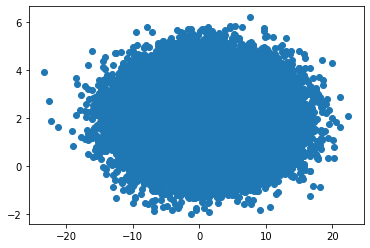

In [7]:
dataset1 = sample_data_1()
plt.scatter(dataset1[:, 0], dataset1[:, 1])

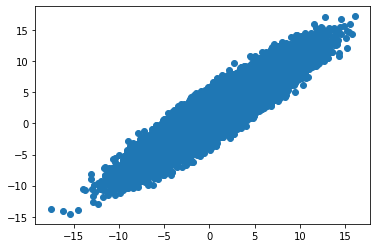

In [8]:
dataset2 = sample_data_2()
plt.scatter(dataset2[:, 0], dataset2[:, 1])

In [0]:
def sample(decoder, n_samples=100000):
    z = torch.randn([n_samples, 2]).cuda()
    mu_x, var_x = decoder(z)
    x = torch.randn([n_samples, 2]).cuda() * torch.sqrt(var_x) + mu_x
    return x, mu_x

In [0]:
def plot_samples(noisy_x, mu_x):
    noisy_x, mu_x = noisy_x.cpu().data.numpy(), mu_x.cpu().data.numpy()
    plt.scatter(noisy_x[:, 0], noisy_x[:, 1], label="samples")
    plt.scatter(mu_x[:, 0], mu_x[:, 1], label="mean")
    plt.legend()

In [0]:
def var_calcer_1(log_var):
    return torch.exp(log_var)

In [0]:
def var_calcer_2(log_var):
    return torch.exp(log_var * torch.ones([1, 2], dtype=torch.float32).cuda())

In [0]:
class MyNet(nn.Module):
    def __init__(self, out_size, var_calcer, n_layers=3, n_features=128):
        super(MyNet, self).__init__()
        self.n_features = n_features
        self.n_layers = n_layers
        self.layers = nn.ModuleList()
        self.out_size = out_size
        self.var_calcer = var_calcer

        self.layers.append(nn.Linear(2, self.n_features))
        for i in range(n_layers - 2):
            self.layers.append(nn.Linear(n_features, self.n_features))
        self.outlayer = nn.Linear(self.n_features, out_size)
            
    def forward(self, x):
        for layer in self.layers:
            x = torch.relu(layer(x))
        mu, log_var = torch.split(self.outlayer(x), 2, dim=1)
        var = self.var_calcer(log_var)
        return mu, var

In [0]:
num_epoch = 7
lr = 1e-3
batch_size = 256

In [0]:
def train(encoder, decoder, data):
    train_size = data.shape[0]
    optimizer1, optimizer2 = Adam(encoder.parameters(), lr=lr), Adam(decoder.parameters(), lr=lr)
    KLD, losses, var = [], [], []

    for _ in range(num_epoch):
        idx = np.random.permutation(train_size)
        for j in range(train_size // batch_size):
            batch = torch.from_numpy(data[idx[j * batch_size : (j + 1) * batch_size]]).float().cuda()
            mu_z, var_z = encoder(batch)
            mu_x, var_x = decoder(mu_z + torch.sqrt(var_z) * torch.randn(batch.shape).cuda())

            nll, KL = MyLoss(batch, mu_x, var_x), KLDiv(mu_z, var_z)
            total_loss = torch.mean(nll + KL)
            optimizer1.zero_grad()
            optimizer2.zero_grad()
            total_loss.backward()
            optimizer1.step()
            optimizer2.step()

            losses.append(torch.mean(nll).detach().item() / 2.0)
            KLD.append(torch.mean(KL).detach().item())
            var.append(torch.mean(-total_loss).detach().item())
            
    return var, KLD, losses

In [0]:
encoder = MyNet(4, var_calcer_1).cuda()
decoder = MyNet(4, var_calcer_1).cuda()
var, KLD_, losses = train(encoder, decoder, dataset1)

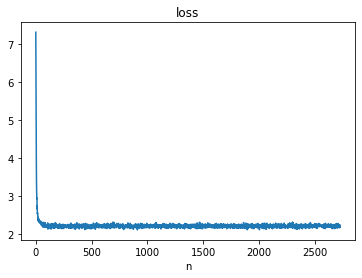

In [17]:
plot_data(losses, "loss")

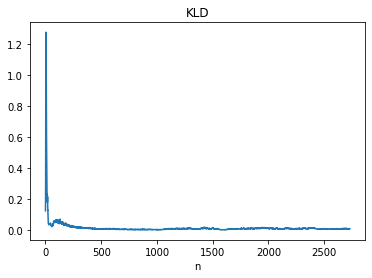

In [18]:
plot_data(KLD_, "KLD")

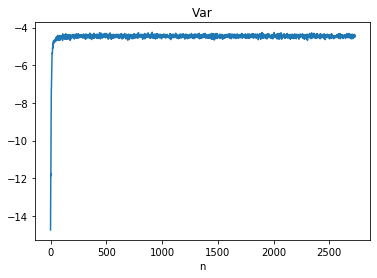

In [19]:
plot_data(var, "Var")

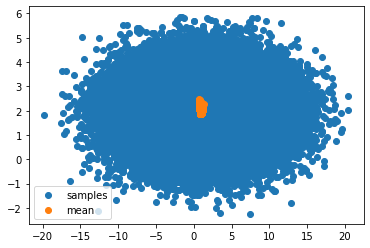

In [20]:
x, mu_x = sample(decoder, 100000)
plot_samples(x, mu_x)

In [0]:
encoder = MyNet(4, var_calcer_1).cuda()
decoder = MyNet(4, var_calcer_1).cuda()
var, KLD_, losses = train(encoder, decoder, dataset2)

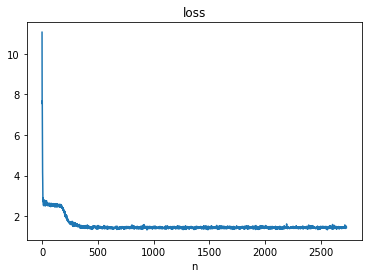

In [22]:
plot_data(losses, "loss")

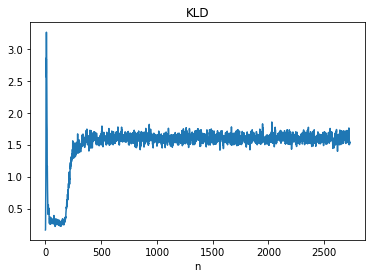

In [23]:
plot_data(KLD_, "KLD")

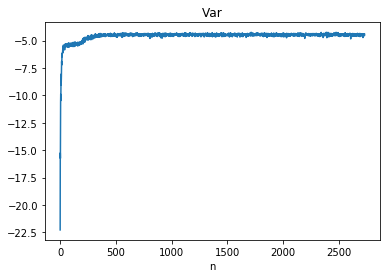

In [24]:
plot_data(var, "Var")

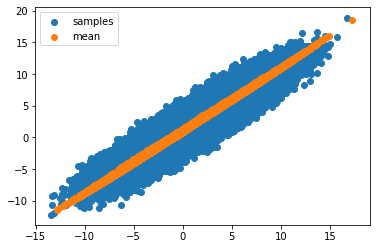

In [25]:
x, mu_x = sample(decoder, 100000)
plot_samples(x, mu_x)

In [0]:
encoder = MyNet(4, var_calcer_1).cuda()
decoder = MyNet(3, var_calcer_2).cuda()
var, KLD_, losses = train(encoder, decoder, dataset1)

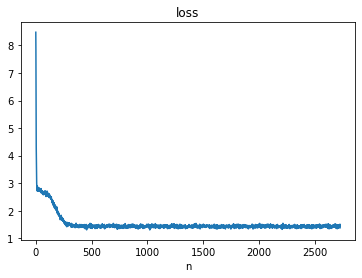

In [27]:
plot_data(losses, "loss")

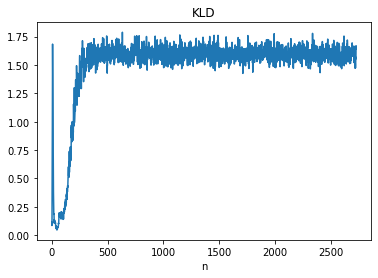

In [28]:
plot_data(KLD_, "KLD")

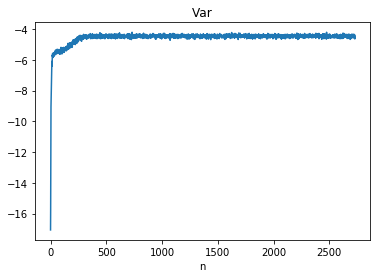

In [29]:
plot_data(var, "Var")

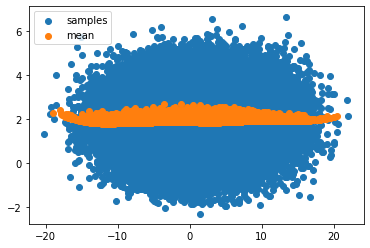

In [30]:
x, mu_x = sample(decoder, 100000)
plot_samples(x, mu_x)

In [0]:
encoder = MyNet(4, var_calcer_1).cuda()
decoder = MyNet(3, var_calcer_2).cuda()
var, KLD_, losses = train(encoder, decoder, dataset2)

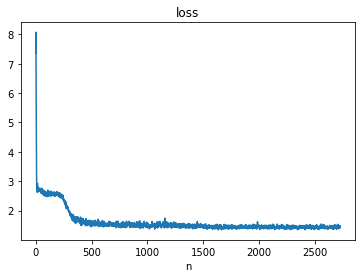

In [32]:
plot_data(losses, "loss")

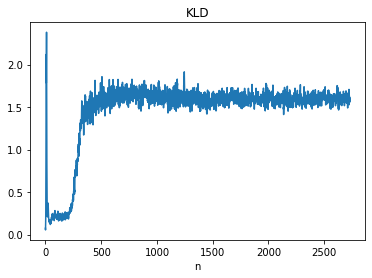

In [33]:
plot_data(KLD_, "KLD")

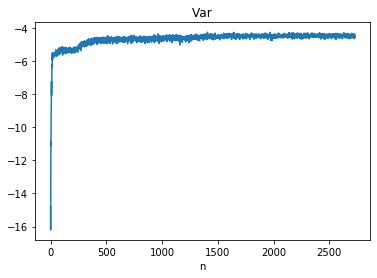

In [34]:
plot_data(var, "Var")

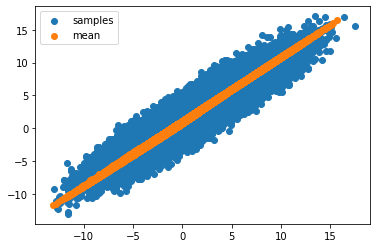

In [35]:
x, mu_x = sample(decoder, 100000)
plot_samples(x, mu_x)